<a href="https://colab.research.google.com/github/kumiori/mec647/blob/main/En_passant_SarahPolystyrene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import site
import sys


try : 
    from google.colab import files
except:
    pass
    
try:
    from fenics import *; from mshr import *
except ImportError as e:
    !apt-get install software-properties-common
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y fenics    
    site.addsitedir('/usr/lib/petsc/lib/python3/dist-packages')  # Always appends to end

    from fenics import *; from mshr import *
    from ufl import replace

!fenics-version

Reading package lists... Done
Building dependency tree       
Reading state information... Done
software-properties-common is already the newest version (0.96.24.32.14).
0 upgraded, 0 newly installed, 0 to remove and 15 not upgraded.
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [44.8 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://ppa.lau

In [2]:
import matplotlib.pyplot as plt
import numpy as np

**Energy**
$$
E(u, \alpha):= \frac{1}{2}\int_\Omega 
\underbrace{a(\alpha) E \mathbb{C(\nu)}}_{\sigma(\alpha)} e(u) : e(u) + \frac{G_c}{c_w}\int \frac{\alpha}{\ell}+\ell |\nabla \alpha|^2 dx
$$

where $u = ..., \ell=$

In [3]:
# Geometry

L1=0.06;
L = 0.06/L1; H = 0.03/L1;
l0 = 0.003/L1; w = 0.005/L1;
L1=(L-w)/2;
L2=(L+w)/2;
H1=H-l0;
epsilon = 0.005; 


plate = Rectangle(Point(0,0), Point(L, H))

notchVertices1 = [Point(L2-epsilon, H), Point(L2 , H1), Point(L2 + epsilon , H)]
notch1 = Polygon(notchVertices1)
notchVertices2 = [Point(L1+epsilon, 0), Point(L1 , l0), Point(L1 - epsilon ,0)]
notch2 = Polygon(notchVertices2)

domain = plate - notch1 - notch2 

cellSize = .02
nel = H / cellSize
mesh   = generate_mesh(domain, nel)


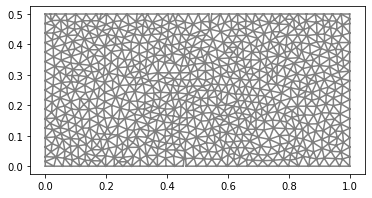

In [4]:
 plot(mesh)

In [5]:
ndim = mesh.topology().dim()

cell_mrk = MeshFunction('bool', mesh, ndim)
cell_mrk.set_all(False)

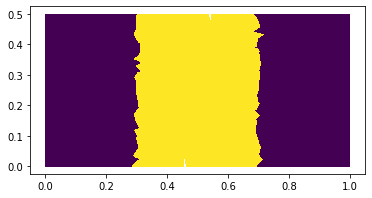

In [6]:
for cell in cells(mesh):
  if 0.3 < cell.midpoint()[0] < 0.7:
    cell_mrk[cell] = True

plot(cell_mrk)

for i in range(2): mesh = refine(mesh, cell_mrk)
# mesh = refine(mesh, cell_mrk)

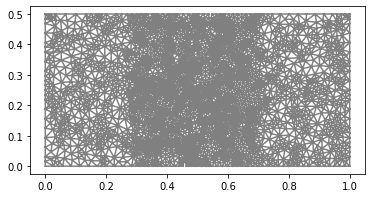

In [7]:
plot(mesh)

In [8]:
V_u = VectorFunctionSpace(mesh, 'CG', 1)
V_alpha = FunctionSpace(mesh, 'CG', 1)

u = Function(V_u)
du = TrialFunction(V_u)
v = TestFunction(V_u)

alpha = Function(V_alpha)
beta = TestFunction(V_alpha)
dalpha = TrialFunction(V_alpha)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [9]:
ut = Expression('t', t=0., degree=0)

bcs_u = [DirichletBC(V_u.sub(0), ut, 'near(x[0], {}, 1e-5)'.format(0)), 
         DirichletBC(V_u.sub(0), Constant(0.), 'near(x[0], {}, 1e-5)'.format(L))]


bca_0 = DirichletBC(V_alpha, Constant(0.), 'near(x[0], {}, 1e-5)'.format(0))
bca_1 = DirichletBC(V_alpha, Constant(0.), 'near(x[0], {}, 1e-5)'.format(L))

bc_alpha = [bca_0, bca_1]

In [10]:
# Constitutive

# Constitutive functions

E, nu = Constant(1000000000.), Constant(0.03)
#Gc = Constant(1294)
ell = Constant(4.82)

ndim = mesh.topology().dim()

def w(alpha):
  return alpha

def a(alpha):
  return (1-alpha)**2

def eps(u):
  return sym(grad(u))

def sigma0(u):
  mu = E/(2.*(1.+nu))
  lmbda = E*nu/(1-nu**2.)
  return (2*mu*eps(u) + lmbda*tr(eps(u))*Identity(ndim))/E

def sigma(alpha, u):
  return a(alpha)*sigma0(u)

In [11]:
print(f'ell {ell.values()[0]}')
print(f'h min {mesh.hmin():2f}')


ell 4.82
h min 0.005636


In [13]:
# Energetics

elastic_energy = 0.5*inner(sigma(alpha, u), eps(u))*dx
dissipated_energy =(w(alpha)/ell + ell* inner(grad(alpha), grad(alpha)))*dx

total_energy = elastic_energy + dissipated_energy 

E_u = derivative(total_energy, u, v)

from ufl import replace
E_du = replace(E_u, {u: du})

E_alpha = derivative(total_energy, alpha, beta)
E_alpha_alpha = derivative(E_alpha,alpha, dalpha)

In [14]:
# Construction of linear and bilinear forms

# problem_u = LinearVariationalProblem()
problem_u = LinearVariationalProblem(lhs(E_du), rhs(E_du), u, bcs_u)
solver_u = LinearVariationalSolver(problem_u)
solver_u.parameters.update({"linear_solver" : "umfpack"})

# Alternatively, compute explicitly:

A = inner(sigma(alpha, du), eps(v))*dx
# f0, g0 exist in L^2(\Omega), L^2(\partial\Omega)
# LL = dot(f0, v)*dx + dot(g0, v)*ds
zero = project(Constant((0., 0.)), V_u)
LL = dot(zero, v)*dx

problem_u = LinearVariationalProblem(A, LL, u, bcs_u)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [15]:
# u = TrialFunction(V_u)
ut.t = -0.1
solver_u.solve()

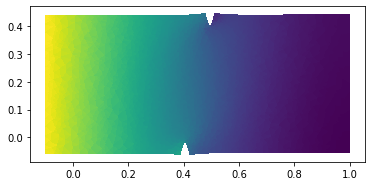

In [16]:
plot(u, mode='displacement')

In [31]:
# Bounds

upperbound = project(Constant(1.), V_alpha)
lowerbound = project(Constant(0.), V_alpha)

# Boundary conditions
# set damage = 0 where we impose displacement boundary conditions

# bc_a1 = DirichletBC(V_alpha, Constant(0.), left)
# bc_a2 = DirichletBC(V_alpha, Constant(0.), right)

# bc_a = [bc_a1, bc_a2]

# Nonlinear problem and solver

problem_alpha = NonlinearVariationalProblem(E_alpha, alpha, bc_alpha, J=E_alpha_alpha)
problem_alpha.set_bounds(lowerbound, upperbound)

# solver able to solve with bounds: SNES

solver_alpha = NonlinearVariationalSolver(problem_alpha)
# info(solver_alpha.parameters, True)

snes_solver_parameters_bounds = {"nonlinear_solver": "snes", 
                                 "snes_solver": {"maximum_iterations": 300,
                                                 "absolute_tolerance": 1e-10,
                                                 "relative_tolerance": 1e-5,
                                                 "solution_tolerance": 1e-5,
                                                 "report": True,
                                                 "linear_solver" : "mumps"
                                                 }
                                }
# Solver method  |  Description                                                 
# ------------------------------------------------------------------------------
# bicgstab       |  Biconjugate gradient stabilized method                      
# cg             |  Conjugate gradient method                                   
# default        |  default linear solver                                       
# gmres          |  Generalized minimal residual method                         
# minres         |  Minimal residual method                                     
# mumps          |  MUMPS (MUltifrontal Massively Parallel Sparse direct Solver)
# petsc          |  PETSc built in LU solver                                    
# richardson     |  Richardson method                                           
# superlu        |  SuperLU                                                     
# tfqmr          |  Transpose-free quasi-minimal residual method                
# umfpack        |  UMFPACK (Unsymmetric MultiFrontal sparse LU factorization)  

solver_alpha.parameters.update(snes_solver_parameters_bounds)
solver_alpha.solve()



(1, True)

In [32]:
# boundaries
gauche = CompiledSubDomain("near(x[0], {}, 1e-4)".format(0))
droite = CompiledSubDomain("near(x[0], {}, 1e-4)".format(L))

boundaries = MeshFunction("size_t", mesh, 1)
boundaries.set_all(0)
gauche.mark(boundaries, 1) # mark gauche as 1
droite.mark(boundaries, 2) # mark droite as 2
ds = Measure("ds",subdomain_data=boundaries) # gauche: ds(1), droite: ds(2),


In [36]:
def alternate_minimisation(alpha, u,
                           alpha_0 = project(Constant(0.), V_alpha),
                           tol=1e-5, maxiter=100):
  alpha_diff = Function(V_alpha)
  iter = 1; error = 1
  alpha.vector()[:] = alpha_0.vector()
  
  while iter < maxiter and error > tol:
    solver_u.solve()
    # u: solution

    solver_alpha.solve()
    # alpha: solution
    # alpha0: alpha at previous timestep

    alpha_diff.vector()[:] = alpha.vector() - alpha_0.vector()
    error = norm(alpha_diff.vector(), 'l2')
    print("Iteration %d, error %e, alpha_max=%.3f"%(iter, error, max(alpha.vector())))
    alpha_0.assign(alpha)

    iter = iter+1

  return (iter, error)

In [37]:
# alpha = Function(V_alpha)
ut.t = -13.
alternate_minimisation(alpha, u)

Iteration 1, error 3.766071e+01, alpha_max=0.691
Iteration 2, error 5.786909e+00, alpha_max=0.826
Iteration 3, error 2.143938e+00, alpha_max=0.889
Iteration 4, error 1.039851e+00, alpha_max=0.925
Iteration 5, error 5.897838e-01, alpha_max=0.948
Iteration 6, error 3.716166e-01, alpha_max=0.964
Iteration 7, error 2.488567e-01, alpha_max=0.974
Iteration 8, error 1.699414e-01, alpha_max=0.982
Iteration 9, error 1.153261e-01, alpha_max=0.987
Iteration 10, error 7.618544e-02, alpha_max=0.991
Iteration 11, error 4.824184e-02, alpha_max=0.993
Iteration 12, error 2.961155e-02, alpha_max=0.995
Iteration 13, error 1.844901e-02, alpha_max=0.996
Iteration 14, error 1.236083e-02, alpha_max=0.997
Iteration 15, error 9.237444e-03, alpha_max=0.998
Iteration 16, error 7.741090e-03, alpha_max=0.998
Iteration 17, error 6.951438e-03, alpha_max=0.998
Iteration 18, error 6.365624e-03, alpha_max=0.998
Iteration 19, error 5.813198e-03, alpha_max=0.998
Iteration 20, error 5.282539e-03, alpha_max=0.998
Iteration

(100, 7.108542359533364e-05)

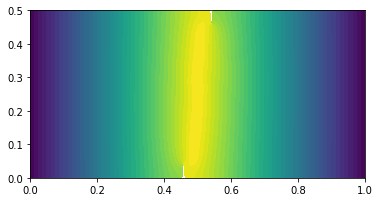

In [38]:
plot(alpha)

In [ ]:
def postprocess():
    tot_en.append(assemble(total_energy))
    sur_en.append(assemble(dissipated_energy))
    ela_en.append(assemble(elastic_energy))
    # assemble(sigma(alpha, u)[1,1]*ds(1))
    react_gauche.append(assemble(sigma(alpha,u)[1,1]*ds(1)))
    print("** elastic = {:.3f}, surface = {:.3f}, total = {:.3f}"
      .format(ela_en[-1], sur_en[-1], tot_en[-1]))
    print("** Converged in {:d} iterations, error = {:.3f}"
      .format(iter, error))

In [ ]:
import os
import shutil

savedir = "results/plate"
if os.path.isdir(savedir):
    shutil.rmtree(savedir)
    
file_alpha = File(savedir+"/alpha.pvd") 
file_u = File(savedir+"/u.pvd")

In [ ]:
file_u << u

In [ ]:
# Evolution monotonically increasing load

loads = np.linspace(.0, -4, 10)

energies = []

tot_en = []
sur_en = []
ela_en = []
react_gauche = []

for (i, t) in enumerate(loads):
  ut.t = t
  print('')
  print("** Load step: t=%.2f"%t)
  (iter, error) = alternate_minimisation(alpha, u, maxiter=200)
  lowerbound.vector()[:] = alpha.vector()
  # postproc
  postprocess()


energies = {'elastic': ela_en, 'surface': sur_en, 'total': tot_en}


** Load step: t=0.00
Iteration 1, error 3.058323e+01, alpha_max=0.000
Iteration 2, error 8.808561e-08, alpha_max=0.000
** elastic = 0.000, surface = 0.000, total = 0.000
** Converged in 3 iterations, error = 0.000

** Load step: t=-0.44
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.048, surface = 0.000, total = 0.048
** Converged in 2 iterations, error = 0.000

** Load step: t=-0.89
Iteration 1, error 0.000000e+00, alpha_max=0.000
** elastic = 0.191, surface = 0.000, total = 0.191
** Converged in 2 iterations, error = 0.000

** Load step: t=-1.33
Iteration 1, error 1.273176e-03, alpha_max=0.001
Iteration 2, error 4.311066e-06, alpha_max=0.001
** elastic = 0.429, surface = 0.000, total = 0.429
** Converged in 3 iterations, error = 0.000

** Load step: t=-1.78
Iteration 1, error 1.098688e-02, alpha_max=0.004
Iteration 2, error 1.979596e-04, alpha_max=0.004
Iteration 3, error 3.518659e-06, alpha_max=0.004
** elastic = 0.763, surface = 0.000, total = 0.763
** Converged i

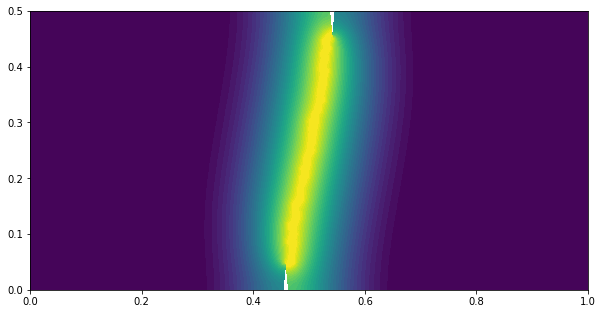

In [ ]:
plt.figure(figsize=(10, 8))
plot(alpha)

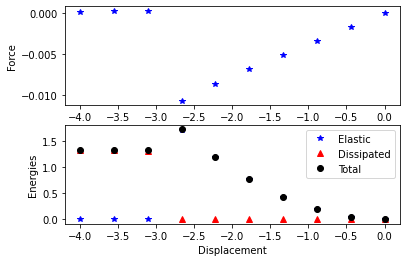

In [ ]:
def plot_stress():
    plt.plot(loads, react_gauche, 'b*', linewidth = 2)
    plt.xlabel('Displacement')
    plt.ylabel('Force')

def plot_energy():
    p1, = plt.plot(loads, energies['elastic'],'b*',linewidth=2)
    p2, = plt.plot(loads, energies['surface'],'r^',linewidth=2)
    p3, = plt.plot(loads, energies['total'],'ko',linewidth=2)
    plt.legend([p1, p2, p3], ["Elastic","Dissipated","Total"])
    plt.xlabel('Displacement')
    plt.ylabel('Energies')


def plot_energy_stress():
    plt.subplot(211)
    plot_stress()
    plt.subplot(212)
    plot_energy()
    plt.savefig('./energies_force.png')
    plt.show()

plot_energy_stress()
